In [1]:
# %pip install azure-cognitiveservices-vision-customvision

### dotenv 관련

In [23]:
import os
import requests
from dotenv import load_dotenv

load_dotenv()

True

### jupyter 환경 에서 gradio 돌릴때 eventloop 중첩 안되게 하는 설정

In [2]:
## jupyter 에서 gradio 돌릴때 eventloop 중첩 안되게 하는 설정
import nest_asyncio
nest_asyncio.apply()

#### 라이브러리 import

In [3]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient 
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient 
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region 
from msrest.authentication import ApiKeyCredentials 
import time, uuid

#### 필수 기본 설정

In [4]:
TRAINING_ENDPOINT = os.getenv("TRAINING_ENDPOINT")
PREDICTION_ENDPOINT = os.getenv("PREDICTION_ENDPOINT")

TRAINING_API_KEY = os.getenv("TRAINING_API_KEY")
PREDICTION_API_KEY = os.getenv("PREDICTION_API_KEY")

PREDICTION_RESOURCE_ID = os.getenv("PREDICTION_RESOURCE_ID")

#### Trainer, Predictor 객체화

In [5]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key" : TRAINING_API_KEY})
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key" : PREDICTION_API_KEY})

trainer = CustomVisionTrainingClient(endpoint=TRAINING_ENDPOINT, credentials=training_credentials)
predictor = CustomVisionPredictionClient(endpoint=PREDICTION_ENDPOINT, credentials=prediction_credentials)

In [6]:
project_list = trainer.get_projects()

for project in project_list :
    print("Project Name :", project.name, "Project Id :", project.id)

domain_list = trainer.get_domains()

for domain in domain_list :
    print("Domain Name :", domain.name, "Domain Id :", domain.id, "Type :", domain.type)

Project Name : 8ai028-kitchen Project Id : ef0a16e0-4bc8-4450-bab9-7f7e7593509a
Domain Name : General [A2] Domain Id : 2e37d7fb-3a54-486a-b4d6-cfc369af0018 Type : Classification
Domain Name : General [A1] Domain Id : a8e3c40f-fb4a-466f-832a-5e457ae4a344 Type : Classification
Domain Name : General Domain Id : ee85a74c-405e-4adc-bb47-ffa8ca0c9f31 Type : Classification
Domain Name : Food Domain Id : c151d5b5-dd07-472a-acc8-15d29dea8518 Type : Classification
Domain Name : Landmarks Domain Id : ca455789-012d-4b50-9fec-5bb63841c793 Type : Classification
Domain Name : Retail Domain Id : b30a91ae-e3c1-4f73-a81e-c270bff27c39 Type : Classification
Domain Name : Adult Domain Id : 45badf75-3591-4f26-a705-45678d3e9f5f Type : Classification
Domain Name : General (compact) [S1] Domain Id : a1db07ca-a19a-4830-bae8-e004a42dc863 Type : Classification
Domain Name : General (compact) Domain Id : 0732100f-1a38-4e49-a514-c9b44c697ab5 Type : Classification
Domain Name : Food (compact) Domain Id : 8882951b-82

#### 프로젝트 만들기

In [7]:
project_name = "8ai028-kitchen"
project_description = "포크와 가위를 감지하는 모델"

project_id = ""
domain_id = ""

project_list = trainer.get_projects()

for project in project_list :

    if project_name == project.name :
        print("Project Name :", project.name, "Project Id :", project.id)
        print("프로젝트 불러옴")
        project_id = project.id
        break

for domain in domain_list :

    if domain.type == "ObjectDetection" and domain.name == "General (compact)" :
        print("Domain Name :", domain.name, "Domain Id :", domain.id, "Type :", domain.type)
        domain_id = domain.id
        break

if project_id == "" :
    project = trainer.create_project(project_name, project_description, domain_id=domain_id)
    print("프로젝트 새로 생성함")

Project Name : 8ai028-kitchen Project Id : ef0a16e0-4bc8-4450-bab9-7f7e7593509a
프로젝트 불러옴
Domain Name : General (compact) Domain Id : a27d5ca5-bb19-49d8-a70a-fec086c47f5b Type : ObjectDetection


#### 태그 만들기

In [8]:
FORK_TAG_NAME = "포크"
SCISSORS_TAG_NAME = "가위"

fork_tag = None
scissors_tag = None

for tag in trainer.get_tags(project_id) :

    if tag.name == FORK_TAG_NAME :
        fork_tag = tag
        print("포크 태그를 들고옴")
    
    if tag.name == SCISSORS_TAG_NAME :
        scissors_tag = tag
        print("가위 태그를 들고옴")

if fork_tag is None :
    fork_tag = trainer.create_tag(project_id, FORK_TAG_NAME)
    print("포크 태그를 만들었음")

if scissors_tag is None :
    scissors_tag = trainer.create_tag(project_id, SCISSORS_TAG_NAME)
    print("가위 태그를 만들었음")

print(fork_tag.id, fork_tag.name)
print(scissors_tag.id, scissors_tag.name)

가위 태그를 들고옴
포크 태그를 들고옴
ea832621-c721-421c-9ae1-a9e17a1394db 포크
f5dc7620-45e5-4d96-bd4b-06196e8e662f 가위


#### 라벨링 데이터

In [9]:
fork_image_regions = {
    "fork_1": [ 0.145833328, 0.3509314, 0.5894608, 0.238562092 ],
    "fork_2": [ 0.294117659, 0.216944471, 0.534313738, 0.5980392 ],
    "fork_3": [ 0.09191177, 0.0682516545, 0.757352948, 0.6143791 ],
    "fork_4": [ 0.254901975, 0.185898721, 0.5232843, 0.594771266 ],
    "fork_5": [ 0.2365196, 0.128709182, 0.5845588, 0.71405226 ],
    "fork_6": [ 0.115196079, 0.133611143, 0.676470637, 0.6993464 ],
    "fork_7": [ 0.164215669, 0.31008172, 0.767156839, 0.410130739 ],
    "fork_8": [ 0.118872553, 0.318251669, 0.817401946, 0.225490168 ],
    "fork_9": [ 0.18259804, 0.2136765, 0.6335784, 0.643790841 ],
    "fork_10": [ 0.05269608, 0.282303959, 0.8088235, 0.452614367 ],
    "fork_11": [ 0.05759804, 0.0894935, 0.9007353, 0.3251634 ],
    "fork_12": [ 0.3345588, 0.07315363, 0.375, 0.9150327 ],
    "fork_13": [ 0.269607842, 0.194068655, 0.4093137, 0.6732026 ],
    "fork_14": [ 0.143382356, 0.218578458, 0.7977941, 0.295751631 ],
    "fork_15": [ 0.19240196, 0.0633497, 0.5710784, 0.8398692 ],
    "fork_16": [ 0.140931368, 0.480016381, 0.6838235, 0.240196079 ],
    "fork_17": [ 0.305147052, 0.2512582, 0.4791667, 0.5408496 ],
    "fork_18": [ 0.234068632, 0.445702642, 0.6127451, 0.344771236 ],
    "fork_19": [ 0.219362751, 0.141781077, 0.5919118, 0.6683006 ],
    "fork_20": [ 0.180147052, 0.239820287, 0.6887255, 0.235294119 ]
}

scissors_image_regions = {
    "scissors_1": [ 0.4007353, 0.194068655, 0.259803921, 0.6617647 ],
    "scissors_2": [ 0.426470578, 0.185898721, 0.172794119, 0.5539216 ],
    "scissors_3": [ 0.289215684, 0.259428144, 0.403186262, 0.421568632 ],
    "scissors_4": [ 0.343137264, 0.105833367, 0.332107842, 0.8055556 ],
    "scissors_5": [ 0.3125, 0.09766343, 0.435049027, 0.71405226 ],
    "scissors_6": [ 0.379901975, 0.24308826, 0.32107842, 0.5718954 ],
    "scissors_7": [ 0.341911763, 0.20714055, 0.3137255, 0.6356209 ],
    "scissors_8": [ 0.231617644, 0.08459154, 0.504901946, 0.8480392 ],
    "scissors_9": [ 0.170343131, 0.332957536, 0.767156839, 0.403594762 ],
    "scissors_10": [ 0.204656869, 0.120539248, 0.5245098, 0.743464053 ],
    "scissors_11": [ 0.05514706, 0.159754932, 0.799019635, 0.730392158 ],
    "scissors_12": [ 0.265931368, 0.169558853, 0.5061275, 0.606209159 ],
    "scissors_13": [ 0.241421565, 0.184264734, 0.448529422, 0.6830065 ],
    "scissors_14": [ 0.05759804, 0.05027781, 0.75, 0.882352948 ],
    "scissors_15": [ 0.191176474, 0.169558853, 0.6936275, 0.6748366 ],
    "scissors_16": [ 0.1004902, 0.279036, 0.6911765, 0.477124184 ],
    "scissors_17": [ 0.2720588, 0.131977156, 0.4987745, 0.6911765 ],
    "scissors_18": [ 0.180147052, 0.112369314, 0.6262255, 0.6666667 ],
    "scissors_19": [ 0.333333343, 0.0274019931, 0.443627447, 0.852941155 ],
    "scissors_20": [ 0.158088237, 0.04047389, 0.6691176, 0.843137264 ]
}

#### 이미지 파일 경로 테스트

In [10]:
for file_name in fork_image_regions.keys() :
    with open(f"./images/fork/{file_name}.jpg", "rb") as image_file :
        image_data = image_file.read()
        print(file_name, image_data[:20])

for file_name in scissors_image_regions.keys() :
    with open(f"./images/scissors/{file_name}.jpg", "rb") as image_file :
        image_data = image_file.read()
        print(file_name, image_data[:20])

fork_1 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_2 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_3 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_4 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_5 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_6 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_7 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_8 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_9 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_10 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_11 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_12 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_13 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00'
fork_14 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\

#### 이미지 업로드

In [16]:
image_list = list()

for file_name, bounding_box in fork_image_regions.items() :

    with open(f"./images/fork/{file_name}.jpg", "rb") as image_file :
        image_data = image_file.read()
        left, top, width, height = bounding_box

        region = Region(tag_id=fork_tag.id, left=left, top=top, width=width, height=height)
        regions = [ region ]
        image_list.append(ImageFileCreateEntry(name=file_name, contents=image_data, regions=regions))


for file_name, bounding_box in scissors_image_regions.items() :

    with open(f"./images/scissors/{file_name}.jpg", "rb") as image_file :
        image_data = image_file.read()
        left, top, width, height = bounding_box

        region = Region(tag_id=scissors_tag.id, left=left, top=top, width=width, height=height)
        regions = [ region ]
        image_list.append(ImageFileCreateEntry(name=file_name, contents=image_data, regions=regions))

batch = ImageFileCreateBatch(images=image_list)

result = trainer.create_images_from_files(project_id=project.id, batch=batch)

for image in result.images :
    print("{} : {}".format(image.source_url, image.status))

scissors_18 : OK
scissors_15 : OK
scissors_14 : OK
scissors_5 : OK
scissors_8 : OK
fork_14 : OK
scissors_7 : OK
fork_17 : OK
fork_8 : OK
fork_20 : OK
fork_18 : OK
fork_19 : OK
fork_12 : OK
fork_10 : OK
fork_6 : OK
scissors_16 : OK
scissors_13 : OK
scissors_1 : OK
fork_16 : OK
fork_15 : OK
fork_9 : OK
fork_7 : OK
scissors_10 : OK
fork_4 : OK
scissors_17 : OK
scissors_20 : OK
scissors_6 : OK
scissors_9 : OK
scissors_4 : OK
scissors_3 : OK
fork_1 : OK
scissors_19 : OK
scissors_12 : OK
scissors_11 : OK
scissors_2 : OK
fork_3 : OK
fork_13 : OK
fork_11 : OK
fork_5 : OK
fork_2 : OK


#### 트레이닝

In [18]:
iteration_list = trainer.get_iterations(project.id)

iteration = None

if len(iteration_list) > 0 :
    iteration = iteration_list[0]
else :
    iteration = trainer.train_project(project.id)

print(iteration.id, iteration.status)

while iteration.status == "Training" :
    print("{} : {}".format(iteration.name, iteration.status))
    iteration = trainer.get_iteration(project.id, iteration.id)
    time.sleep(5)

cd6f5e55-7f9b-40eb-a18b-fa840aa5f50d Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1 : Training
Iteration 1

#### 배포

In [21]:
publish_name = "8ai028kitchen-v1"

try :
    trainer.publish_iteration(project.id, iteration.id, publish_name, PREDICTION_RESOURCE_ID)
    print("{} 모델이 게시되었습니다.".format(publish_name))

except Exception as e :
    print("{} 모델은 이미 게시된 모델입니다.".format(publish_name))


8ai028kitchen-v1 모델이 게시되었습니다.


#### 예측

포크 : 83.49%
가위 : 77.31%
포크 : 43.81%


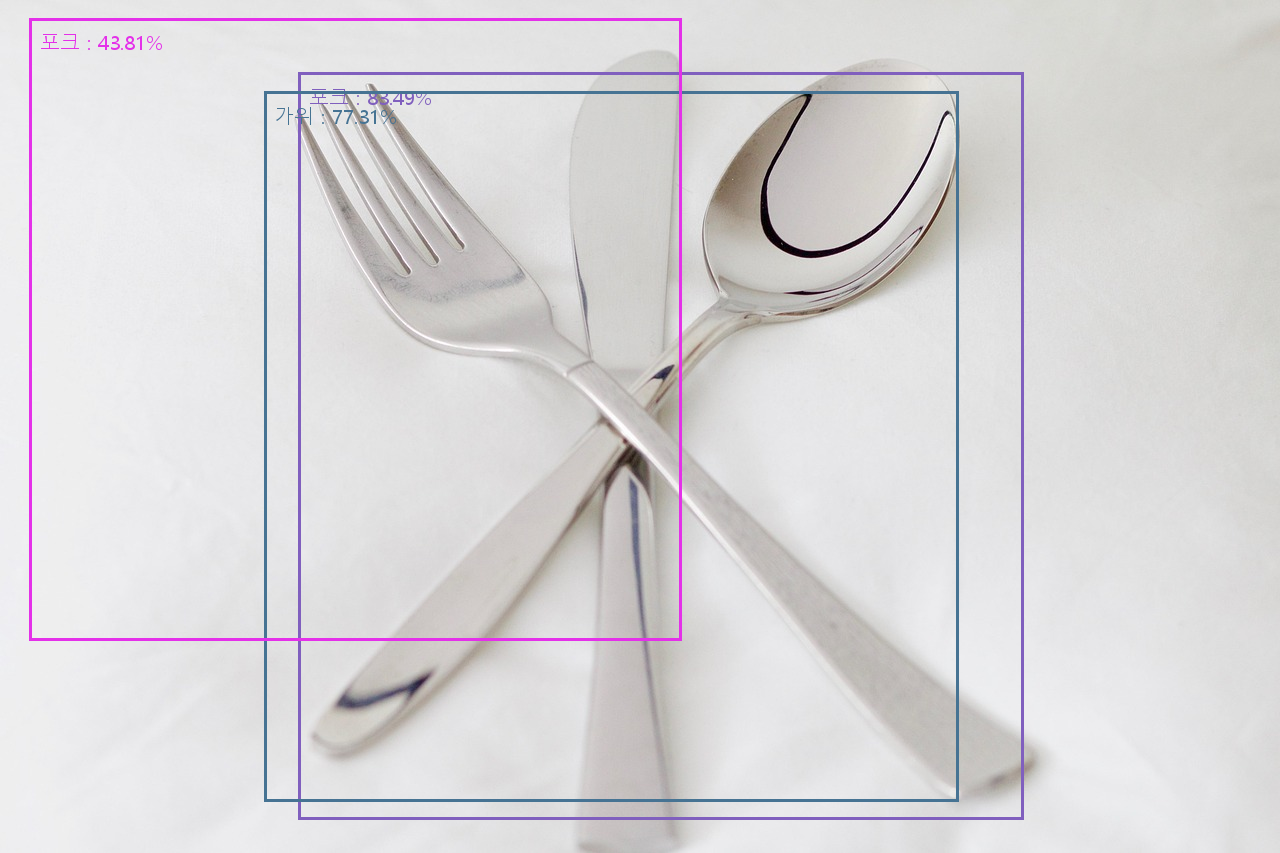

In [25]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import platform
import random

def random_color():
  return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 


def get_font():
  font_size = 20
  try:
      if platform.system() == "Windows":
          # 윈도우: 맑은 고딕
          return ImageFont.truetype("malgun.ttf", font_size)
      elif platform.system() == "Darwin":  # macOS
          # 맥: 애플 고딕
          return ImageFont.truetype("AppleGothic.ttf", font_size)
      else:  # Linux 등
          # 기본 폰트 (한글 지원 안 될 수 있음)
          return ImageFont.load_default(size=font_size)
  except IOError:
      # 지정한 폰트 파일이 없을 경우 PIL 기본 폰트 사용
      return ImageFont.load_default()


image_response = requests.get("https://cdn.pixabay.com/photo/2016/08/20/22/23/spoon-1608678_1280.jpg")

image_data = image_response.content
image = Image.open(BytesIO(image_data))
draw = ImageDraw.Draw(image)

image_width = image.width
image_height = image.height
font = get_font()

prediction_response = predictor.detect_image(project.id, publish_name, image_data)

# response = predictor.detect_image_url(project.id, publish_name, "https://cdn.pixabay.com/photo/2016/08/20/22/23/spoon-1608678_1280.jpg")
predictions = prediction_response.predictions

for prediction in predictions :

    color = random_color()

    if prediction.probability > 0.3 :
        tag_name = prediction.tag_name
        probability = prediction.probability
        bounding_box = prediction.bounding_box

        x = bounding_box.left * image_width
        y = bounding_box.top * image_height
        w = bounding_box.width * image_width
        h = bounding_box.height * image_height

        draw.rectangle([(x, y), (x + w, y +h )], outline=color, width=3)
        draw.text((x + 10, y + 10), "{} : {:.2f}%".format(tag_name, probability * 100), fill=color, font=font)
        print("{} : {:.2f}%".format(prediction.tag_name, prediction.probability*100))

display(image)